In [178]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [223]:
class MarkovChain:
    def __init__(self, transition_matrix, initial_probabilities, values=None):
        if len(transition_matrix.shape) != 2:
            raise ValueError("Not matrix input")
        if transition_matrix.shape[0] != transition_matrix.shape[1]:
            raise ValueError("Incorrect transition matrix size")
        if transition_matrix.shape[0] != initial_probabilities.shape[0]:
            raise ValueError("Inconsistency of the sizes of transition matrix and initial probabilities vector")
        
        self._P = transition_matrix
        self._v0 = initial_probabilities
        self._x = np.arange(1, len(initial_probabilities) + 1) if values is None else values
        self._indeces = np.arange(len(initial_probabilities))


    def _simulate(self, t):
        index = np.random.choice(a=self._indeces, p=self._v0)
        simulation_values = np.array([self._x[index]])
        simulation_times = np.array([0])
        for step in range(1, t+1):
            p_list = self._P[index]
            index = np.random.choice(a=self._indeces, p=p_list)
            simulation_values = np.append(simulation_values, self._x[index])
            simulation_times = np.append(simulation_times, step)
        return simulation_values, simulation_times

    
    def simulation(self, t, num_simulations=None):
        """
        :param num_simulations: int or None - number of simulations. If None, it will be
        performed only one simulation.
        :return tuple(np.ndarray, np.array) - matrix of size num_simulations by t+1 (or np.array if num_simulations is None) 
        with values of random variable at all times and times array
        """
        if num_simulations is None:
            return self._simulate(t)
        simulations_values = np.empty((0, t + 1))
        simulations_times = np.arange(0, t + 1)
        for _ in range(num_simulations):
            sim_values = self._simulate(t)[0]
            simulations_values = np.append(simulations_values, sim_values.reshape(1, -1), axis=0)
        return simulations_values, simulations_times


    def simulation_values(self, t, num_simulations=None):
        """
        Same as MarkovChain.simulation but returns only values of random variable 
        at time moment t (final moment).
        """
        if num_simulations is None:
            return self._simulate(t)[0][-1]
        return self.simulation(t, num_simulations)[0][:, -1].ravel()


    def get_states(self):
        return np.copy(self._x)


    def get_theoretical_distribution(self, t, decimal=4):
        return np.round(self._v0 @ np.linalg.matrix_power(self._P, t), decimal)

In [224]:
def show_trajectory(simulation_results, title="Markov chain simulation"):
    values, times = simulation_results
    x_ticks = np.linspace(np.min(times), np.max(times), 5)
    y_ticks = np.arange(np.min(values)-2, np.max(values)+3)

    plt.scatter(times, values, s=50, c='m', label='Simulation values')
    plt.plot(times, values, "c")

    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")

    plt.legend()
    plt.grid(True)
    plt.show()

In [225]:
test_TPM = np.array([[0.0, 0.0, 1.0, 0.0, 0.0], 
                     [1.0, 0.0, 0.0, 0.0, 0.0], 
                     [0.4, 0.6, 0.0, 0.0, 0.0], 
                     [0.1, 0.4, 0.2, 0.3, 0.0],
                     [0.0, 0.0, 0.0, 0.5, 0.5]])
test_init_p1 = np.array([1/3, 1/3, 0.0, 0.0, 1/3])
test_init_p2 = np.array([0.0, 0.0, 0.5, 0.5, 0.0])

t_list = [5, 10, 20]
N = 100

mc1 = MarkovChain(test_TPM, test_init_p1)
mc2 = MarkovChain(test_TPM, test_init_p2)

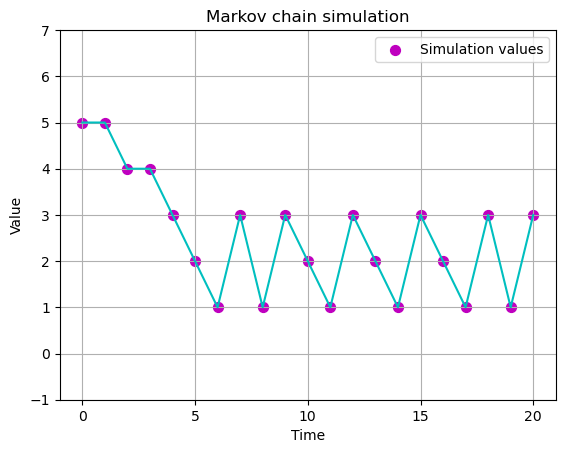

In [227]:
assert mc1.simulation(t=8)[0].shape[0] == 9
assert mc1.simulation(t=10)[0].shape[0] == 11

assert mc1.simulation(t=5, num_simulations=10)[0].shape[0] == 10
assert mc1.simulation(t=5, num_simulations=10)[0].shape[1] == 6
assert mc2.simulation(t=10, num_simulations=20)[0].shape[1] == mc2.simulation(t=10, num_simulations=20)[1].shape[0]

assert mc1.simulation_values(t=4, num_simulations=20).shape[0] == 20
assert mc2.simulation_values(t=1, num_simulations=35).shape[0] == 35

show_trajectory(mc1.simulation(t=20))

In [228]:
def get_distribution(mc, t, num_simulations=5, density=True):
    """
    Getting distribution of Markov chain simulation
    :param mc: MarkovChain object - for which chain will be performed all simulations
    :param t: int - time of all simulations
    :param sum_simulations: int - number of simulations, which will be performed
    """
    divider = num_simulations if density else 1
    states = mc.get_states()
    values = mc.simulation_values(t, num_simulations)
    data = dict.fromkeys(states, 0)
    for val in values: 
        data[val] += 1
    return {state: counter/divider for state, counter in data.items()}


def create_histogram(data, colors, title='Sample cross-section distribution'):
    """
    Creating bar by distribution
    :param data: dict - data
    """
    plt.bar(list(data.keys()), list(data.values()), color=colors)
    plt.xlabel('States')
    plt.ylabel('Probabilities estimation')
    plt.title(title)
    plt.show()

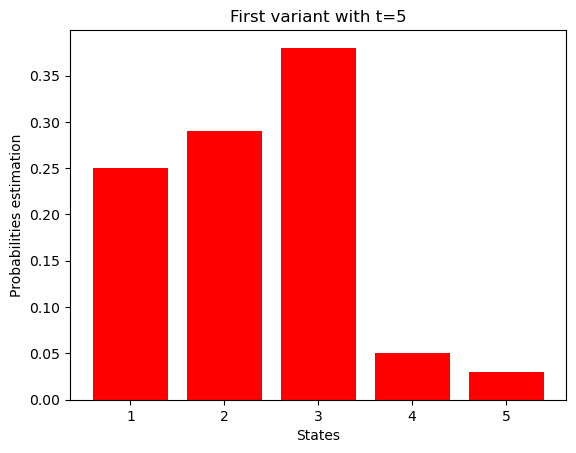

In [229]:
color_list_1 = ["red"] * 5
color_list_2 = ["yellow"] * 5

data1 = get_distribution(mc=mc1, t=t_list[0], num_simulations=N)
create_histogram(data, color_list_1, f"First variant with t={t_list[0]}")

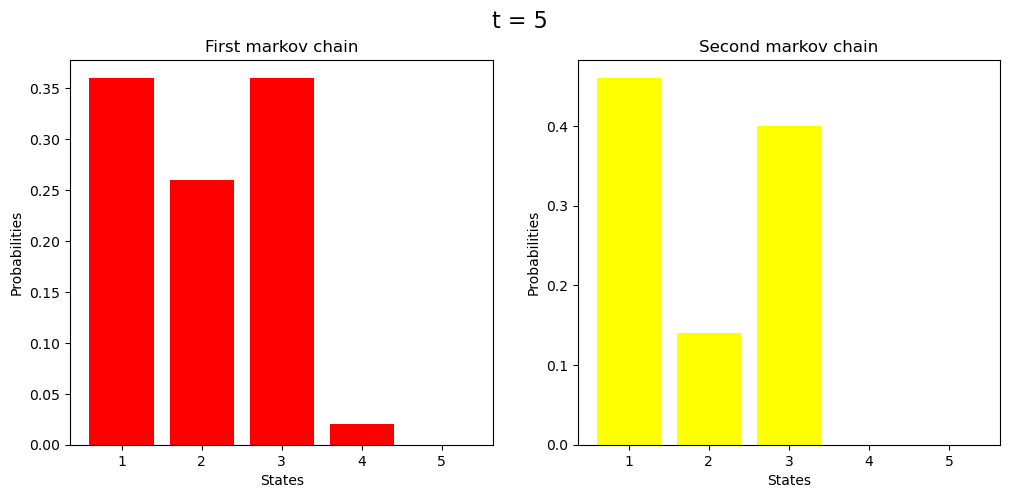

In [230]:
data1 = get_distribution(mc=mc1, t=t_list[0], num_simulations=N)
data2 = get_distribution(mc=mc2, t=t_list[0], num_simulations=N)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle(f"t = {t_list[0]}", fontsize=16)

ax[0].bar(list(data1.keys()), list(data1.values()), color=color_list_1)
ax[0].set_xlabel('States')
ax[0].set_ylabel('Probabilities')
ax[0].set_title('First markov chain')

ax[1].bar(list(data2.keys()), list(data2.values()), color=color_list_2)
ax[1].set_xlabel('States')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Second markov chain')

plt.show()

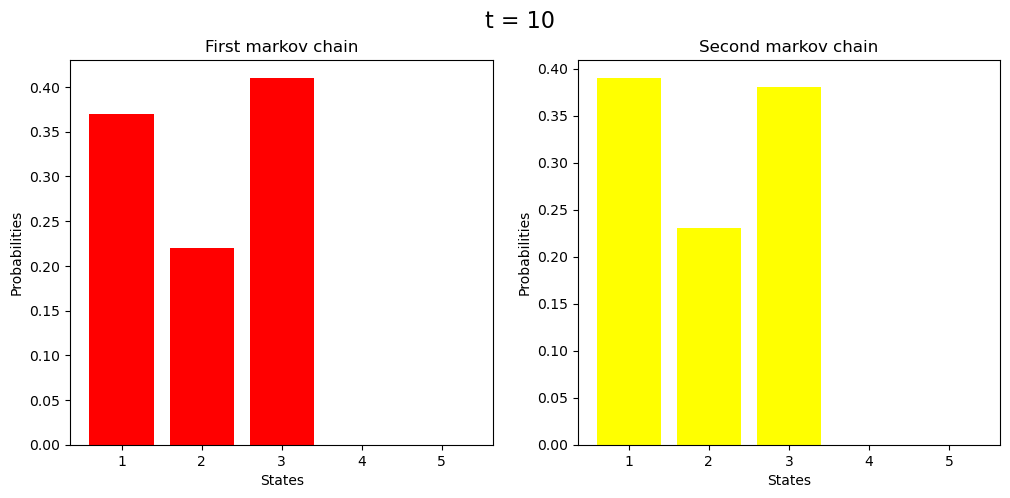

In [231]:
data1 = get_distribution(mc=mc1, t=t_list[1], num_simulations=N)
data2 = get_distribution(mc=mc2, t=t_list[1], num_simulations=N)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle(f"t = {t_list[1]}", fontsize=16)

ax[0].bar(list(data1.keys()), list(data1.values()), color=color_list_1)
ax[0].set_xlabel('States')
ax[0].set_ylabel('Probabilities')
ax[0].set_title('First markov chain')

ax[1].bar(list(data2.keys()), list(data2.values()), color=color_list_2)
ax[1].set_xlabel('States')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Second markov chain')

plt.show()

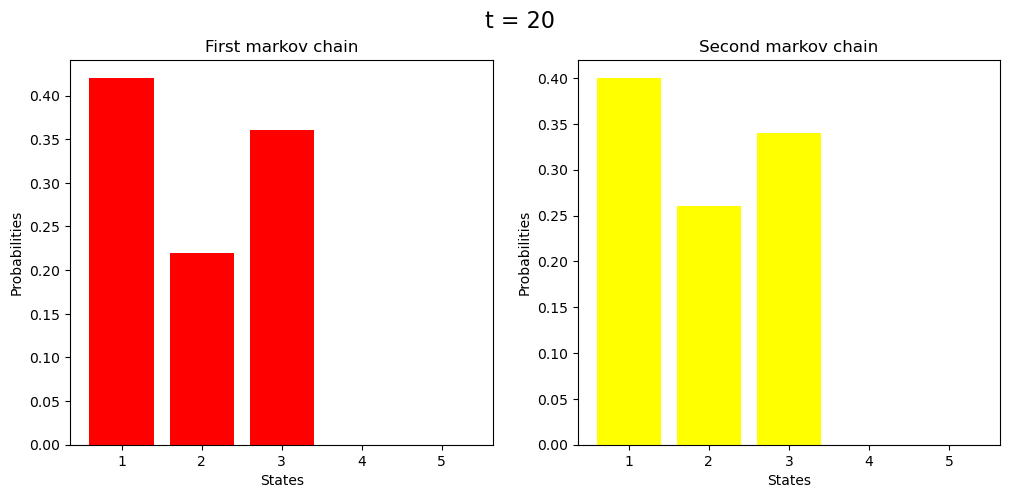

In [213]:
data1 = get_distribution(mc=mc1, t=t_list[2], num_simulations=N)
data2 = get_distribution(mc=mc2, t=t_list[2], num_simulations=N)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle(f"t = {t_list[2]}", fontsize=16)

ax[0].bar(list(data1.keys()), list(data1.values()), color=color_list_1)
ax[0].set_xlabel('States')
ax[0].set_ylabel('Probabilities')
ax[0].set_title('First markov chain')

ax[1].bar(list(data2.keys()), list(data2.values()), color=color_list_2)
ax[1].set_xlabel('States')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Second markov chain')

plt.show()

In [246]:
print("--First markov chain--")
for t in t_list:
    sim_data = get_distribution(mc=mc1, t=t, num_simulations=N)
    theor_data = mc1.get_theoretical_distribution(t=t)
    print(f"    t={t}") 
    print("Simulations:", list(sim_data.values()))
    print("Theoretical:", theor_data, end='\n\n')

print('\n\n')

print("--Second markov chain--")
for t in t_list:
    sim_data = get_distribution(mc=mc2, t=t, num_simulations=N)
    theor_data = mc2.get_theoretical_distribution(t=t)
    print(f"    t={t}") 
    print("Simulations:", list(sim_data.values()))
    print("Theoretical:", theor_data, end='\n\n')

--First markov chain--
    t=5
Simulations: [0.36, 0.22, 0.41, 0.0, 0.01]
Theoretical: [0.3204 0.2839 0.3612 0.024  0.0104]

    t=10
Simulations: [0.41, 0.21, 0.38, 0.0, 0.0]
Theoretical: [3.667e-01 2.255e-01 4.067e-01 8.000e-04 3.000e-04]

    t=20
Simulations: [0.29, 0.24, 0.47, 0.0, 0.0]
Theoretical: [0.3861 0.2301 0.3838 0.     0.    ]




--Second markov chain--
    t=5
Simulations: [0.37, 0.22, 0.41, 0.0, 0.0]
Theoretical: [0.4399 0.1451 0.4138 0.0012 0.    ]

    t=10
Simulations: [0.36, 0.34, 0.3, 0.0, 0.0]
Theoretical: [0.4104 0.2331 0.3565 0.     0.    ]

    t=20
Simulations: [0.42, 0.21, 0.37, 0.0, 0.0]
Theoretical: [0.3828 0.232  0.3852 0.     0.    ]

